# "Self-Attention Explained: Improving GNNs with Attention"
> Graph Attention Networks on CiteSeer

- toc: false 
- badges: true
- comments: true
- categories: [graph neural networks, graph attention networks, GAT, self-attention, tutorial]
- image: images/gat/thumbnail.png
- permalink: /gat/
- hidden: true

<center><div id="anim_container"><img alt="CiteSeer" src="https://mlabonne.github.io/blog/images/gat/citeseer_yed.png" loading="lazy" id="anim_inner" width="800"></div></center>

In the [previous article](https://mlabonne.github.io/blog/intrognn/), we implemented our **first Graph Neural Network** (GNN) with a **graph convolutional layer**. We saw that nodes have features, but we can get **even more information** by looking at their **neighbors' features**. Graph convolutional layers **contextualize nodes** by **aggregating the features of the nodes they're connected to**. In practice, they simply **calculate the weighted average of these features and normalize the result** by the number of neighbors. The output of this operation is called an **embedding**. During training, Graph Convolutional Networks (GCNs) **learn the best weights** (*i.e.*, how to create the **best embeddings**) to accomplish a task, like node classification.

This approach works well, but **there's something quite weird** when you think about it: we apply the **exact same weights to every node**. It means that we do not distinguish nodes: they all have the **same importance to our GNN**. Indeed, we **divide the result by the number of neighbors**, but it feels like **some nodes should be more essential than others**, regardless of their neighbors. Actually, it's quite surprising that we managed to correctly classify members of the karate club **without this component**.

What we're looking for is called **self-attention**, a powerful technique that recently became **super popular in deep learning**. In this article, we're gonna work with a **new dataset of scientific publications** and explore its graph. We will introduce the **self-attention mechanism and how it works for GNNs**. Finally, we'll use it in PyTorch Geometric (PyG) and **compare the results of our Graph Attention Network (GAT) with those of a Graph Convolutional Network (GCN)**. First, let's install the required Python libraries like in the previous article.

In [1]:
# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Numpy for matrices
import numpy as np
np.random.seed(0)

# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 18})

## 🌐 I. Graph data

There are **three classic graph datasets** we can use for this work. They can be found on [the official website of the authors](https://linqs.soe.ucsc.edu/data), the LINQS group at the University of California, Santa Cruz. Each of these datasets consists of a **network of research papers**, where **each connection represents a citation**. In other words, $u \leftrightarrow v$ means that $u$ cited $v$ or $v$ cited $u$ (the graph is not directed). Each paper has features, which **represent the presence of specific words**. Based on these connections and features, the goal is to **correctly classify nodes into predefined categories**. The three datasets are the following:

* [**Cora**](http://www.kamalnigam.com/papers/cora-jnl.pdf): this dataset consists of **2708 machine learning papers** that belong to one of the following **7 categories**: case-based reasoning, genetic algorithms, neural networks, probabilistic methods, reinforcement learning, rule learning, and theory. Node features represent the **presence (1) or absence (0) of 1433 words** in a paper (it's a binary [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model)).
* [**CiteSeer**](https://clgiles.ist.psu.edu/papers/DL-1998-citeseer.pdf): it is a bigger but similar dataset of **3312 scientific papers** to classify into one of the following **6 categories**: agents, AI, DB, IR, ML, and HCI. Once again, node features represent the **presence (1) or absence (0) of 3703 words** in a paper.
* [**PubMed**](http://eliassi.org/papers/ai-mag-tr08.pdf): it is an even bigger dataset with **19717 scientific publications about diabetes** from [PubMed's database](https://pubmed.ncbi.nlm.nih.gov/). The goal is to classify them into one of the following **3 categories**: diabetes mellitus experimental, diabetes mellitus type 1, diabetes mellitus type 2. Node features were calculated differently this time: instead of 0/1-valued word vector indicating the absence/presence of the corresponding word, they're described by a **[TF-IDF weighted word vector](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) from a dictionary of 500 unique words**.

These datasets have been **widely used by the scientific community**. As a challenge, we can compare our future results to those obtained in the [literature](https://arxiv.org/pdf/1710.10903.pdf) by **Multilayer Perceptrons** (MLPs), **Graph Convolutional Networks** (GCNs), and **Graph Attention Networks** (GATs). The following table summarizes **classification accuracies** for each model on each dataset:
<br/>
<br/>

| Dataset | 📝Cora | 📝CiteSeer | 📝PubMed |
| :--- | :---: | :---: | :---: |
| MLP | 55.1% | 46.5% | 71.4% |
| GCN | 81.5% | 70.3% | **79.0%** |
| GAT | **83.0%** | **72.5%** | **79.0%** |

<br/>

**PubMed is quite large** so it would **take longer to process it and train a GNN** on it. Cora is the **most studied one** in the literature, so let's **focus on CiteSeer** as a middle ground. We can directly import any of them in PyTorch Geometric with the [**Planetoid class**](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid) (we just have to change `name` to "Cora" or "PubMed").

In [2]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="CiteSeer")

Let's explore this dataset and check if our information was **correct**...

In [3]:
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: CiteSeer()
-------------------
Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6

Graph:
------
Edges are directed: False
Graph has isolated nodes: True
Graph has loops: False


Interestingly enough, we have **3327 nodes instead of 3312**! I don't exactly know what happened, but PyTorch Geometric actually uses [this paper's](https://arxiv.org/pdf/1603.08861.pdf) implementation of CiteSeer, **which also displays 3327 nodes**. We could investigate a little further, but we would **get even more sidetracked**, so let's pretend the mystery is solved for now...

More importantly, we have the **correct number of classes and features**. The edges are not directed and the graph doesn't have any loop, but **some nodes are isolated**! Based on what we know from this dataset, we can assume that **correctly classifying these isolated nodes will be a challenge since we cannot rely on any aggregation or connections**. It could even maybe explain **why CiteSeer obtains lower accuracy scores than the two other datasets**. There are several ways of counting the number of isolated nodes, such as using PyG's utility function [`remove_isolated_nodes`](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch_geometric.utils.remove_isolated_nodes).

In [4]:
from torch_geometric.utils import remove_isolated_nodes

(remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()

48

We see **48 isolated nodes** in CiteSeer, which is just over 1% of the total dataset. Surely, **it doesn't help but we cannot entirely blame them** for the poor accuracy scores. Indeed, it cannot explain a difference of about 10% compared to the other datasets. Maybe there's **another problem**, or maybe the data is just of **poor quality**. ¯\\\_(ツ)\_/¯

To finish the data exploration stage, I'd like to **visualize our dataset**. However, this step is **quite computationally intensive** so I'm gonna comment the code (feel free to execute it if you want) and directly display the output. Actually, the first image of this article is **also a representation of CiteSeer**, made with [yEd Live](https://www.yworks.com/yed-live/).

In [5]:
#collapse-hide
# from torch_geometric.utils import to_networkx

# G = to_networkx(data, to_undirected=True)
# plt.figure(figsize=(18,18))
# plt.axis('off')
# nx.draw_networkx(G,
#                 pos=nx.spring_layout(G, seed=0),
#                 with_labels=False,
#                 node_size=50,
#                 node_color=data.y,
#                 width=2,
#                 edge_color="grey"
#                 )
# plt.show()

<center><div id="anim_container"><img alt="CiteSeer" src="https://mlabonne.github.io/blog/images/gat/citeseer.png" loading="lazy" id="anim_inner" width="600"></div></center>

This graph **looks much more complex than Zachary's karate club**. We can see a **massive cluster of interconnected papers** in the center, and **small communities and isolated nodes** on its periphery. This could be the real challenge of CiteSeer: these small communities **might not provide enough information to correctly classify them**. It would be interesting to **check this hypothesis later** with the results.

The graph gives us information about the **number of connections of each node**. But we can directly plot it in a more **rigorous and presentable** way with `degree`:

<BarContainer object of 32 artists>

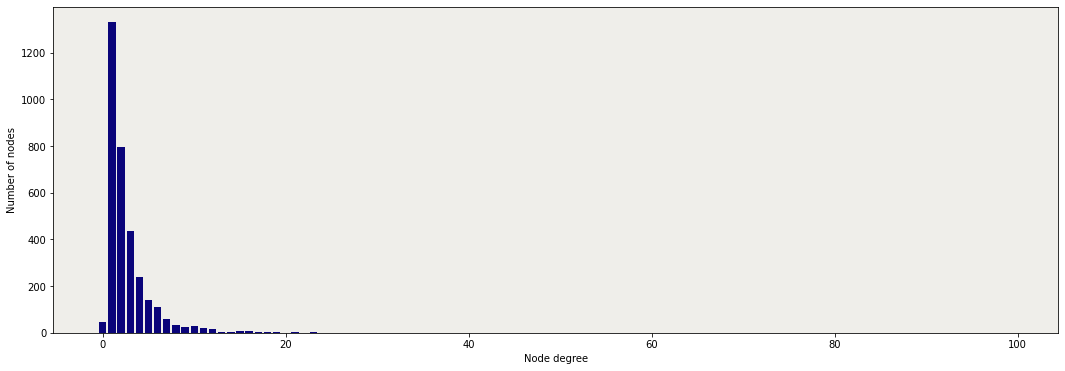

In [6]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 6))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
ax.set_facecolor('#EFEEEA')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

We see that most nodes have **1 or 2 neighbors**: this is not a lot! Hopefully, it will be **enough** for our GAT to get good results...

Alright, I think we built a **good understanding** of the dataset. We could also check the **words in the dictionary and the different classes**, but this is not what we're interested in in this article. Let's talk about **self-attention** instead.

## ⚠️ II. Self-attention

### A. How to calculate attention scores

<center><div id="anim_container"><img alt="Graph with attention scores" src="https://mlabonne.github.io/blog/images/gat/graph_attention.png" loading="lazy" id="anim_inner" width="400"></div></center>

Self-attention in GNNs was introduced by [Veličković et al.](https://arxiv.org/abs/1710.10903) in 2017. It relies on a simple idea: **neighboring nodes shouldn't all have the same importance**. The easiest way to achieve it is to **assign a weighting factor (attention score) to each neighbor**. What's even cooler with this approach is that **we don't even need to normalize the result anymore**, since the weighting factors can implicitly calculate it. Let's call $\alpha_{ij}$ the **attention score between the nodes $i$ and $j$**. We can replace the graph convolutional operation as follows:

$$h_i = \sum_{j \in \mathcal{N}_i} \dfrac{1}{\sqrt{deg(i)}\sqrt{deg(j)}} \mathbf{W} x_j$$

<center>becomes</center>

$$h_i=\sum_{j\in\mathcal{N}_i}\alpha_{ij}\mathbf{W}x_j$$

Perfect, it looks cleaner! Now that we **understand why we want self-attention**, how is it calculated? We could try to do it by ourselves, but there's a **more clever way** of doing it: we can let the **GNN learn the best attention scores**. Think about it about it for a second: currently, the graph convolutional layer just **learns the best common weight matrix** $\mathbf{W}$ for its task. But it could become more flexible by **also learning the best attention scores** to achieve it.

Let's take an example with the previous graph: we want to **calculate $h_1$ the embedding of node 1**. We still have **shared weights** $\mathbf{W}$ and **feature vectors** $x_1$, $x_2$, $x_3$, and $x_4$. Here's what the calculation looks like with the additional **attention scores**:

$$h_1 = \alpha_{11}\mathbf{W}x_1 + \alpha_{12}\mathbf{W}x_2 + \alpha_{13}\mathbf{W}x_3 + \alpha_{14}\mathbf{W}x_4$$

In the previous article, we just **normalized this sum** (albeit in a clever way) and **that was it**. But we can **refine these hidden feature vectors to extract more information** out of them. Let's call them $\tilde{h_i}$ to show that they can be **considered as inputs**.

$$\tilde{h_i} = \mathbf{W}x_i \tag{1}$$

The previous equation can be rewritten as follows:

$$h_1 = \alpha_{11}\tilde{h_1} + \alpha_{12}\tilde{h_2} + \alpha_{13}\tilde{h_3} + \alpha_{14}\tilde{h_4}$$

Okay, what do we do with these **hidden feature vectors**? We can't just apply a second linear transformation on them: it **wouldn't be very useful**. If we remember the **concept of attention scores**, they are not weights you apply to node features, but **to connections**. It means that we need **pairs of hidden feature vectors instead of single ones**.

<center><div id="anim_container"><img alt="Calculate attention scores step 1" src="https://mlabonne.github.io/blog/images/gat/attention_calculation1.png" loading="lazy" id="anim_inner" height="400"></div></center>

An easy way to create these pairs is to concatenate vectors. Only then can we apply a **linear transformation with a dedicated matrix** $W_{att}$ and, finally, an activation function (the authors chose $LeakyReLU$ in this case).

$$e_{ij} = LeakyReLU(W_{att}^t[\tilde{h}_i\mathbin\Vert \tilde{h}_j])\tag{2}$$

<center><div id="anim_container"><img alt="Calculate attention scores step 2" src="https://mlabonne.github.io/blog/images/gat/attention_calculation2.png" loading="lazy" id="anim_inner" height="400"></div></center>

Oops, I lied: there's an **extra step** to obtain the actual $\alpha_{ij}$. What we calculated are **un-normalized attention scores**. But to make them **easily comparable** across different nodes, we have to **normalize** them with a $softmax$ function.

$$\alpha_{ij} = softmax_j(e_{ij}) = \frac{exp(e_{ij})}{\sum_{k \in \mathcal{N}_i}{exp(e_{ik})}}\tag{3}$$

<center><div id="anim_container"><img alt="Calculate attention scores step 3" src="https://mlabonne.github.io/blog/images/gat/attention_calculation3.png" loading="lazy" id="anim_inner" height="400"></div></center>

Here you have it: how to calculate every $\alpha_{ij}$. The only problem is... **self-attention is not very stable**. In order to improve performance, [Vaswani et al.](https://arxiv.org/abs/1706.03762) introduced **multi-head attention** in the Transformer architecture. Wait, Transformer? This is only **slightly surprising** since we've only been talking about self-attention so far, but in reality **Transformers are Graph Neural Networks in disguise**. Their architecture is a **little more complicated** (they have three attention weight matrices for instance), but this is a topic for another day. Feel free to [watch this video](https://www.youtube.com/watch?v=FWFA4DGuzSc) if you're interested in Transformers.

<center><div id="anim_container"><img alt="Calculate attention scores step 4" src="https://mlabonne.github.io/blog/images/gat/attention_calculation4.png" loading="lazy" id="anim_inner" height="400"></div></center>

In GATs, multi-head attention consists of **replicating the same operation several times in order to average or concatenate the results**. That's it. Instead of a single $h_1$, we get **one $h_1^k$ per attention head**. One of the two following schemes can then be applied:

* **Average**: we sum the different $h_i^k$ and normalize the result by the number of attention heads $n$;

$$h_i = \frac{1}{n}\sum_{k=1}^n{h_i^k}$$

* **Concatenation**: we concatenate the different $h_i^k$.

$$h_i = \mathbin\Vert_{k=1}^n{h_i^k}$$

In practice, people tend to use the **concatenation scheme when the graph attention layer is a hidden layer**, and the **average scheme when it's the last one**.

<center class="dark-bg">
    <video autoplay loop muted width="800" class="no-margin">
        <source src="https://mlabonne.github.io/blog/images/gat/gat_animation.mp4" type="video/mp4"></source>
    </video>
</center>

### B. (Optional) Reimplementing a GAT from scratch

Now that we know the theory, let's try to **translate these equations into matrix multiplications**. This part is **optional** since it's more **advanced**. You don't need to know how to **reimplement a graph attention network from scratch** in NumPy, but it can help you to **better understand the nitty-gritty details**.

We're going to use a **graph with 4 nodes**, whose feature vectors are just **one-hot encoding** of their indexes. We randomly initialize two matrices: `W` for the first linear transformation, and `W_att` for the attention weight matrix.

In [7]:
in_dim = 4
out_dim = 2

# Node features (one-hot encoding)
X = np.eye(in_dim, in_dim)
print('X =')
print(X)

# Adjacency matrix
A = np.array([
    [0, 1, 0, 1], # 1 -> 2, 4
    [1, 0, 1, 0], # 2 -> 1, 3
    [0, 1, 0, 0], # 3 -> 2
    [1, 0, 0, 0]  # 4 -> 1
])
# Adjacency matrix with self-loops
A = A + np.identity(A.shape[0])
print('\nA_tilde =')
print(A)

# Randomly initialize the weight matrix
W = np.random.uniform(-1, 1, (out_dim, X.shape[0]))
print('\nW =')
print(W)

# Randomly initialize the attention weight matrix
W_att = np.random.uniform(-1, 1, (1, out_dim*2))
print('\nAttention weight matrix W_att =')
print(W_att)

X =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

A_tilde =
[[1. 1. 0. 1.]
 [1. 1. 1. 0.]
 [0. 1. 1. 0.]
 [1. 0. 0. 1.]]

W =
[[ 0.09762701  0.43037873  0.20552675  0.08976637]
 [-0.1526904   0.29178823 -0.12482558  0.783546  ]]

Attention weight matrix W_att =
[[ 0.92732552 -0.23311696  0.58345008  0.05778984]]


Okay, we initialized all the variables. If we look back at the GAT equations, we have:

$$\tilde{h_i} = \mathbf{W}x_i \tag{1}$$

As in regular neural networks, the first step is to calculate the **linear transformation** $\mathbf{W}X$ to obtain the hidden features $h$. Note that these hidden features **only have 2 dimensions** (`out_dim`) instead of 4 (`in_dim`). Usually, you want to **increase** the number of dimensions, but I chose 2 in this example to keep things readable.

In [8]:
# Linear transformation WX
h = X @ W.T
print('h =')
print(h)

h =
[[ 0.09762701 -0.1526904 ]
 [ 0.43037873  0.29178823]
 [ 0.20552675 -0.12482558]
 [ 0.08976637  0.783546  ]]


In a simple feedforward layer, we would just feed $\tilde{h}$ to a non-linear function like $tanh$ or $ReLU$ and **that would be it**. But we have more work to do with this **graph attention layer**. The second equation calculates the **un-normalized attention scores**:

$$e_{ij} = LeakyReLU(W_{att}^t[\tilde{h}_i\mathbin\Vert \tilde{h}_j])\tag{2}$$

There are three operations in this equation: 1/ **concatenating** $\tilde{h}_i$ and $\tilde{h}_j$; 2/ **multiplying** $W_{att}^t $ by the result of the concatenation; 3/ **applying** the $LeakyReLU$ function to the result of the previous operation.

First, let's **concatenate pairs of hidden features** $\tilde{h}_i$ and $\tilde{h}_j$ from source and destination nodes. A simple way of obtaining pairs of source and destination nodes is to look at our adjacency matrix $\tilde{A}$ in <a href="https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO)">COO</a> format: rows store **source nodes**, and columns store **destination nodes**. Numpy provides a quick and efficient way of doing it with `np.where()`.

In [9]:
connections = np.where(A > 0)
print(f'Source nodes      = {connections[0]}')
print(f'Destination nodes = {connections[1]}')

Source nodes      = [0 0 0 1 1 1 2 2 3 3]
Destination nodes = [0 1 3 0 1 2 1 2 0 3]


Now we can just **concatenate the hidden features** of these nodes with `np.concatenate()`.

In [10]:
print('Hidden features of source nodes =')
print(h[connections[0]])

print('\nHidden features of destination nodes =')
print(h[connections[1]])

concat = np.concatenate([h[connections[0]], h[connections[1]]], axis=1)
print('\nConcatenated hidden features =')
print(concat)

Hidden features of source nodes =
[[ 0.09762701 -0.1526904 ]
 [ 0.09762701 -0.1526904 ]
 [ 0.09762701 -0.1526904 ]
 [ 0.43037873  0.29178823]
 [ 0.43037873  0.29178823]
 [ 0.43037873  0.29178823]
 [ 0.20552675 -0.12482558]
 [ 0.20552675 -0.12482558]
 [ 0.08976637  0.783546  ]
 [ 0.08976637  0.783546  ]]

Hidden features of destination nodes =
[[ 0.09762701 -0.1526904 ]
 [ 0.43037873  0.29178823]
 [ 0.08976637  0.783546  ]
 [ 0.09762701 -0.1526904 ]
 [ 0.43037873  0.29178823]
 [ 0.20552675 -0.12482558]
 [ 0.43037873  0.29178823]
 [ 0.20552675 -0.12482558]
 [ 0.09762701 -0.1526904 ]
 [ 0.08976637  0.783546  ]]

Concatenated hidden features =
[[ 0.09762701 -0.1526904   0.09762701 -0.1526904 ]
 [ 0.09762701 -0.1526904   0.43037873  0.29178823]
 [ 0.09762701 -0.1526904   0.08976637  0.783546  ]
 [ 0.43037873  0.29178823  0.09762701 -0.1526904 ]
 [ 0.43037873  0.29178823  0.43037873  0.29178823]
 [ 0.43037873  0.29178823  0.20552675 -0.12482558]
 [ 0.20552675 -0.12482558  0.43037873  0.29178

Then, we have to **multiply the attention weight matrix with this result**. Technically, we're calculating its **transpose to simplify calculations** but this is not important.

In [11]:
a = W_att @ concat.T
print(a)

[[ 0.17426327  0.39409364  0.22378193  0.37921693  0.5990473   0.44378135
   0.48765606  0.33239011 -0.05127869 -0.00176003]]


Now we can **apply the $ReLU$ function** to the new result.

In [12]:
def leaky_relu(x, alpha=0.2):
  return np.maximum(alpha*x, x)

e = leaky_relu(a)
print('e =')
print(e)

e =
[[ 1.74263270e-01  3.94093638e-01  2.23781929e-01  3.79216929e-01
   5.99047297e-01  4.43781347e-01  4.87656061e-01  3.32390111e-01
  -1.02557380e-02 -3.52006176e-04]]


There's a slight technical problem with `e`: the **un-normalized attention scores** $e_{ij}$ are **not properly stored in a matrix**. It means we **cannot multiply it** with the other matrices. Fortunately enough, we know the **sources** $i$ and **destinations** $j$ thanks to `connections`. So the first value in `e` corresponds to $e_{00}$, the second value to $e_{01}$, the third one to $e_{03}$, etc.

In [13]:
E = np.zeros(A.shape)
E[connections[0], connections[1]] = e[0]
print('E =')
print(E)

E =
[[ 1.74263270e-01  3.94093638e-01  0.00000000e+00  2.23781929e-01]
 [ 3.79216929e-01  5.99047297e-01  4.43781347e-01  0.00000000e+00]
 [ 0.00000000e+00  4.87656061e-01  3.32390111e-01  0.00000000e+00]
 [-1.02557380e-02  0.00000000e+00  0.00000000e+00 -3.52006176e-04]]


Perfect, we have the correct **un-normalized attention matrix** $E$. The final step is just to **normalize the attention scores of every neighbor**.

$$
\alpha_{ij} = softmax_j(e_{ij}) = \frac{exp(e_{ij})}{\sum_{k \in \mathcal{N}_i}{exp(e_{ik})}}\tag{3}
$$

I had to reimplement a **softmax function** for NumPy arrays (and fail a few times in the process), but this is the result $W_{\alpha}$:

In [14]:
def softmax2D(x, axis):
    e = np.exp(x - np.expand_dims(np.max(x, axis=axis), axis))
    sum = np.expand_dims(np.sum(e, axis=axis), axis)
    return e / sum

W_alpha = softmax2D(E, 1)
print('W_alpha =')
print(W_alpha)

W_alpha =
[[0.24173822 0.30117327 0.2030784  0.25401011]
 [0.25019035 0.31170349 0.26687661 0.17122955]
 [0.19909248 0.32422104 0.27759399 0.19909248]
 [0.24810387 0.25066145 0.25066145 0.25057323]]


Alright, we can now **combine our different matrices to translate the graph attention layer equation in terms of matrix multiplications**.

$$h_i=\sum_{j\in\mathcal{N}_i}\alpha_{ij}\mathbf{W}x_j$$

<center>becomes</center>

$$H = \tilde{A}^TW_{\alpha}X\mathbf{W}^T$$

Where each row $i$ of $H$ contains the **embedding** of the node $i$.

In [15]:
H = A.T @ W_alpha @ X @ W.T
print('H =')
print(H)

H =
[[0.65266686 0.57855356]
 [0.68045463 0.56380155]
 [0.46269627 0.33915461]
 [0.42387004 0.42495061]]


Well done, we calculated the **hidden features of our 4 nodes with NumPy from scratch**!

Multi-head attention consists of doing the **same operation for each head** with a **different attention weight matrix**. Therefore, each head **outputs its own hidden feature matrix** $H_i$. Our two previous schemes can be implemented as follows:

* **Average**: we sum the hidden feature matrices and normalize the result by the number of attention heads $n$;

$$H = \frac{1}{n}\sum_{i=1}^n{H_i}$$

* **Concatenation**: we concatenate the different $H_i$, which means that the output dimension will be $n \times out\_dim$ instead of $out\_dim$.

$$H = \mathbin\Vert_{i=1}^n{H_i}$$

We're really done now, no more matrix multiplications! We're gonna use PyTorch Geometric, which **abstracts all these calculations into a single customizable layer**.

## 🧠 III. Graph Attention Networks

There are **two graph attention layers** in PyTorch Geometric: `GATConv` and `GATv2Conv`. What we talked about so far is the `GatConv` layer, but in 2021 [Brody et al.](https://arxiv.org/abs/2105.14491) introduced a **simple improvement by modifying the order of operations**. The weight matrix $\mathbf{W}$ is applied **after the concatenation** and the attention weight matrix **after the $LeakyReLU$ function**. In summary:

* `GatConv`: $e_{ij} = LeakyReLU(W_{att}^t[\mathbf{W}x_i\mathbin\Vert \mathbf{W}x_j])$
* `Gatv2Conv`: $e_{ij} = W_{att}^tLeakyReLU(\mathbf{W}[x_i\mathbin\Vert x_j])$

Which one should you use? According to numerous experiments, **`Gatv2Conv` consistently outperforms `GatConv` and thus should be preferred**.

Let's finally **classify the papers** from CiteSeer! I tried to **roughly reproduce the experiments** of the original authors without adding too much complexity. You can find the **official implementation** of GAT [on GitHub](https://github.com/PetarV-/GAT). Note that we use **graph attention layers in two configurations**: the first one concatenates **8 outputs** (multi-head attention), and the second one only has **1 head**, which produces our **final embeddings**. We're also gonna **train and test a GCN** to **compare the accuracy scores** and see if it corresponds to the authors' claims.

In [16]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)


class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 200

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
          
    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [17]:
%%time
# Initialize, train and test GCN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)
train(gcn, data)
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(3703, 16)
  (gcn2): GCNConv(16, 6)
)
Epoch   0 | Train Loss: 1.777 | Train Acc:  19.17% | Val Loss: 1.81 | Val Acc: 12.60%
Epoch  10 | Train Loss: 0.470 | Train Acc:  91.67% | Val Loss: 1.27 | Val Acc: 53.60%
Epoch  20 | Train Loss: 0.177 | Train Acc:  94.17% | Val Loss: 1.36 | Val Acc: 57.00%
Epoch  30 | Train Loss: 0.108 | Train Acc:  97.50% | Val Loss: 1.52 | Val Acc: 57.20%
Epoch  40 | Train Loss: 0.081 | Train Acc:  98.33% | Val Loss: 1.62 | Val Acc: 57.80%
Epoch  50 | Train Loss: 0.055 | Train Acc:  99.17% | Val Loss: 1.51 | Val Acc: 59.00%
Epoch  60 | Train Loss: 0.090 | Train Acc:  98.33% | Val Loss: 1.54 | Val Acc: 57.00%
Epoch  70 | Train Loss: 0.045 | Train Acc: 100.00% | Val Loss: 1.61 | Val Acc: 54.80%
Epoch  80 | Train Loss: 0.064 | Train Acc:  97.50% | Val Loss: 1.70 | Val Acc: 54.20%
Epoch  90 | Train Loss: 0.062 | Train Acc:  98.33% | Val Loss: 1.51 | Val Acc: 61.80%
Epoch 100 | Train Loss: 0.041 | Train Acc: 100.00% | Val Loss: 1.53 | Val Acc: 6

In [18]:
%%time
# Initialize, train and test GAT model
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)
train(gat, data)
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(3703, 8, heads=8)
  (gat2): GATv2Conv(64, 6, heads=1)
)
Epoch   0 | Train Loss: 1.809 | Train Acc:  20.00% | Val Loss: 1.83 | Val Acc: 14.60%
Epoch  10 | Train Loss: 0.108 | Train Acc:  98.33% | Val Loss: 1.02 | Val Acc: 66.40%
Epoch  20 | Train Loss: 0.013 | Train Acc: 100.00% | Val Loss: 1.17 | Val Acc: 65.40%
Epoch  30 | Train Loss: 0.013 | Train Acc:  99.17% | Val Loss: 1.24 | Val Acc: 65.20%
Epoch  40 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.20 | Val Acc: 63.00%
Epoch  50 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 1.22 | Val Acc: 65.00%
Epoch  60 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.19 | Val Acc: 65.80%
Epoch  70 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.14 | Val Acc: 64.80%
Epoch  80 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 1.13 | Val Acc: 65.40%
Epoch  90 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.14 | Val Acc: 66.60%
Epoch 100 | Train Loss: 0.006 | Train Acc: 100.00% | Val Lo

This experiment is not **super rigorous**: we'd need to **repeat it 100 times** and take the **average accuracy** as the final result. But we can see in this example that the **GAT outperforms the GCN**. The authors obtained **72.5% for the GAT and 70.3% for the GCN**, which is clearly better than we did. The difference can be explained by **some tweaks in the models** and a **different training setting**, where they used a **patience of 100** instead of a fixed number of epochs for instance. However, the GAT **takes longer to train**, which can cause **scalability issues** very large graphs.

Let's **visualize** what the GAT learned. This time, we're gonna use [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), a powerful method to **plot high-dimensional data (3703 features in our case) in 2D or 3D**. First, let's see what the embeddings looked like **before any training**: it should be **absolutely random** since they're produced by **randomly initialized** weight matrices.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


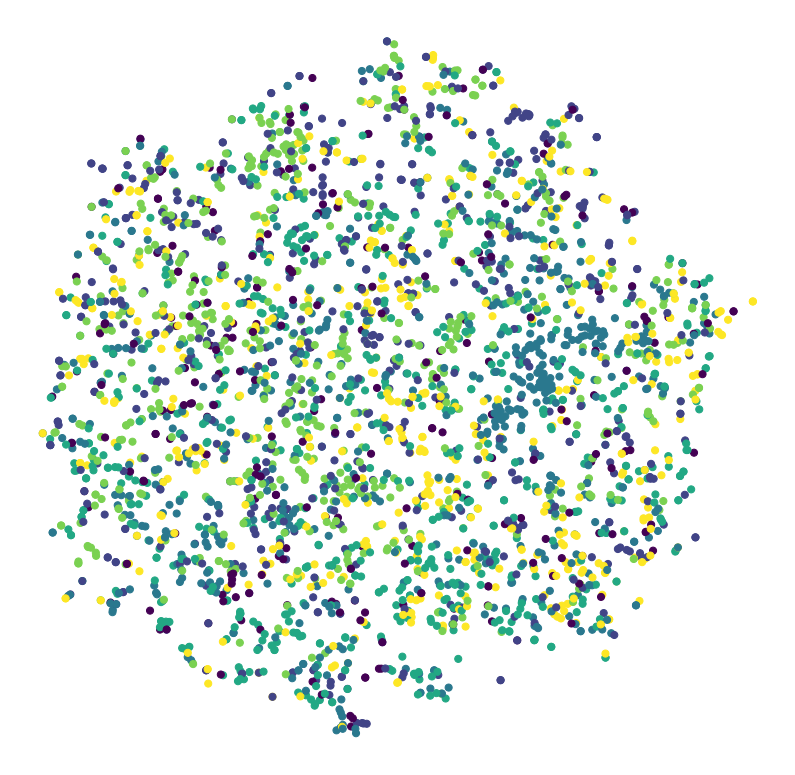

In [19]:
# Initialize new untrained model
untrained_gat = GAT(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(14, 14))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

Indeed, there's **no apparent structure**. But does our trained model **perform better**? Here's the t-SNE plot of our **final embeddings**:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


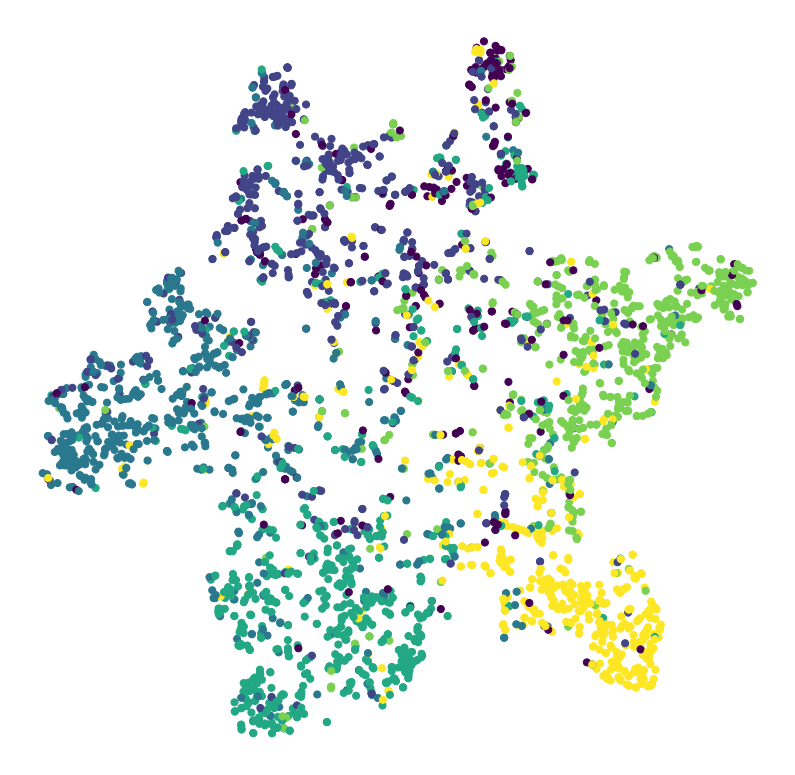

In [20]:
# Get embeddings
h, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(14, 14))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

The difference is noticeable: **nodes belonging to the same classes cluster together**. There are **outliers**, but this was to be expected: our accuracy score is **far from being perfect**.

I forgot something: during the data exploration stage, I speculated that **isolated communities might be the source of the poor performance of CiteSeer** compared to the other two datasets. Demonstrating this rigorously would require **comparative studies**, something we do not have time to do in this article. Even **successfully identifying nodes belonging to isolated communities is time-consuming and difficult**. I propose to do something else: **calculate the model's accuracy for each degree**. In other words, nodes with one neighbor ($deg(i) = 1$), two neighbors ($deg(i) = 2$), etc.

It's not the same thing, but isolated nodes and communities have **few or no connections** to neighbors. Intuitively, they should be **harder to classify**. For this purpose, it is possible to calculate the **degree of each node** in CiteSeer with PyG's utility function `degree`. We can then use `np.where()` to **create a mask** (like train_mask and test_mask) for this particular degree. Finally, we just have to **compute the accuracy scores and plot them** for a swell visualization.

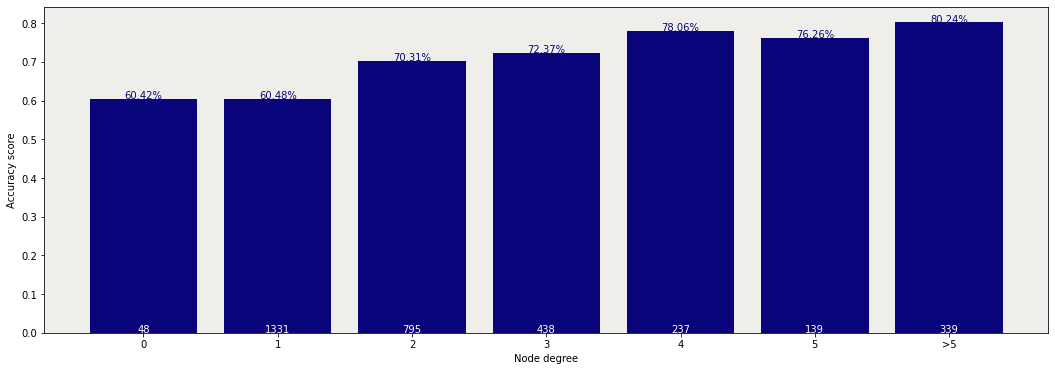

In [21]:
from torch_geometric.utils import degree

# Get model's classifications
_, out = gat(data.x, data.edge_index)

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
  mask = np.where(degrees == i)[0]
  accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
  sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots(figsize=(18, 6))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
ax.set_facecolor('#EFEEEA')
plt.bar(['0','1','2','3','4','5','>5'],
        accuracies,
        color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%',
             ha='center', color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i],
             ha='center', color='white')

Nodes with few neighbors are indeed **harder to classify**. This is due to the nature of GNNs: **the more relevant connections you have, the more information you can aggregate**. Performance **stop increasing after a certain theshold**: in this example, having more than 4 neighbors **doesn't help that much**.

## 🔚 IV. Conclusion

While they **take longer to train**, Graph Attention Networks are a **substantial improvement** over Graph Convolutional Nets in terms of accuracy. The self-attention mechanism **automatically calculates weighting factors instead of static coefficients** to produce **better embeddings**. In this article,

* We explored a **new graph dataset** commonly used in research, and we analyzed more properties like **node degrees**;
* We learned about the **self-attention mechanism applied to GNNs** with the concatenation of hidden features to produce an **attention score** that is normalized for **each connection**;
* We reimplemented a **graph attention layer** in NumPy to get a better understanding of how it works;
* We **compared two architectures** with PyTorch Geometric, a GCN and a GAT, to see the **improvement brought by the attention mechanism**;
* We visualized **what the GAT learns** with the t-SNE plot of our trained and untrained embeddings;
* Finally, we performed a quick **error analysis** based on node degrees.

GATs are the **de facto standard** in most GNN applications. However, their **slow training time can become a problem** when applied to massive graph datasets. **Scalability** is an important factor in deep learning: most often, **more data can lead to better performance** than better models. In the next article, we'll see **how to improve scalability** with mini-batching and a new GNN architecture called [GraphSAGE](https://arxiv.org/abs/1706.02216).

If you enjoyed this tutorial, **please share it on social media** and **[follow me on Twitter](https://twitter.com/maximelabonne)** for more GNN content. Thank you and see you in the next article! 📣